In [1]:
import numpy as np
import scipy.stats as sps
import math
from functools import lru_cache
from tqdm import tqdm, trange
from matplotlib import pyplot as plt
from statsmodels.stats.proportion import proportion_confint 
from typing import Literal

In [2]:
NS = [10, 50, 100, 150, 200, 500]
N = 10 ** 3
FRR = 0.05
FAR = 0.05

A = 5
SIGMA_SQUARED = 3

In [3]:
@lru_cache
def get_distributions(E: float = 0, D: float = 1) -> dict[str, sps.rv_continuous]:
    unif_scale = 2 * math.sqrt(3 * D)
    unif_loc = E - unif_scale / 2
    return {
        'Norm': sps.norm(loc=E, scale=math.sqrt(D)),
        'Uniform': sps.uniform(loc=unif_loc, scale=unif_scale),
        'Exp': sps.expon(loc=E - math.sqrt(D), scale=math.sqrt(D))
    }

In [4]:
@lru_cache
def quant(d, q, n = None):
    match d:
        case 'Norm':
            return sps.norm.ppf(q)
        case 'Student':
            return sps.t.ppf(q, n)
        case 'Chi Squared':
            return sps.chi2.ppf(q, n)

Функция проверки сложной гипотезы о математическом ожидании случайной величины. Возвращает `True`, если следует принять гипотезу $H_0: \text{M}[r] < a$ с заданными $\text{FRR}$ и $\text{FAR}$.

In [5]:
def check_expected_value(sample, less_than: float, frr, far) -> bool:
    n = len(sample)
    x_mean = np.mean(sample)
    s = np.std(sample)
    term = s / math.sqrt(n)
    I_1_r = x_mean + term * quant('Student', 1 - frr, n - 1)
    if I_1_r < less_than:
        return True
    I_2_l = x_mean - term * quant('Student', 1 - far, n - 1)
    if I_2_l > less_than:
        return False
    else:
        return False

In [6]:
def test_solution(what,
                  frr: float,
                  far: float,
                  hypothesis_kwargs: dict[str],
                  distributions: dict[str, sps.rv_continuous],
                  ax: plt.Axes | None = None,
                  include_label: Literal['quantile'] | None = None):
    res = {d: [] for d in distributions}
    interval_res = {d: [] for d in distributions}
    for n in NS:
        for d_name, distro in distributions.items():
            cur_res = 0
            for _ in range(N):
                cur_res += not what(distro.rvs(size=n), **hypothesis_kwargs, frr=frr, far=far)
            res[d_name].append(cur_res / N)
            interval_res[d_name].append(proportion_confint(cur_res, N))
    
    # Plot the results
    if ax is None:
        ax = plt.gca()
    ax.axhline(frr, linestyle='--', color='gray', alpha=0.5)
    for distr_name, distribution in distributions.items():
        match include_label:
            case None:
                label = distr_name
            case 'quantile':
                q = hypothesis_kwargs['q']  # Will raise an error if not provided and it's okay
                label = f'{distr_name}, $x_{{{q}}}$ = {distribution.ppf(q):.2f}'
        y_err = list(map(lambda arr: np.abs(np.subtract(arr, res[distr_name])), zip(*interval_res[distr_name])))
        ax.errorbar(NS, res[distr_name], yerr=y_err, fmt='o-', capsize=3, label=label)
    E, D = list(distributions.items())[0][1].stats('mv')
    ax.title.set_text(f'$M[r] = {round(E, 1):.1f}, D[r] = {round(D, 1):.1f}$')
    ax.set_ylim(-0.05, 1.05)
    ax.set_xscale('log')
    ax.legend()

## Task 2

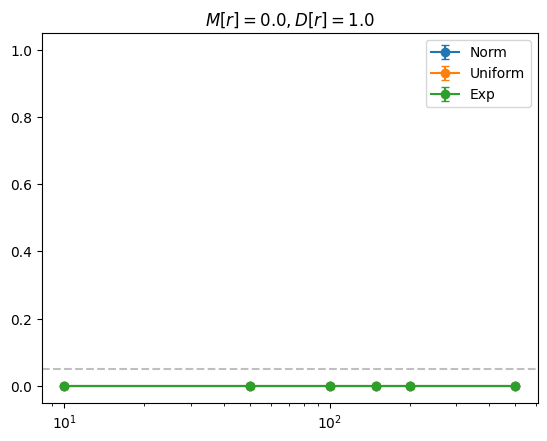

In [7]:
test_solution(check_expected_value, FRR, FAR, hypothesis_kwargs={'less_than': A}, distributions=get_distributions(E=0, D=1))

## Task 3

Посмотрим, как будет меняться эти значения при изменении матожидания распределений.

In [8]:
STEP = 0.2
ES = np.linspace(0.2, 2 * A, num=int((2 * A - 0.2) // STEP))
num_tries = len(ES)

100%|██████████| 49/49 [01:00<00:00,  1.23s/it]


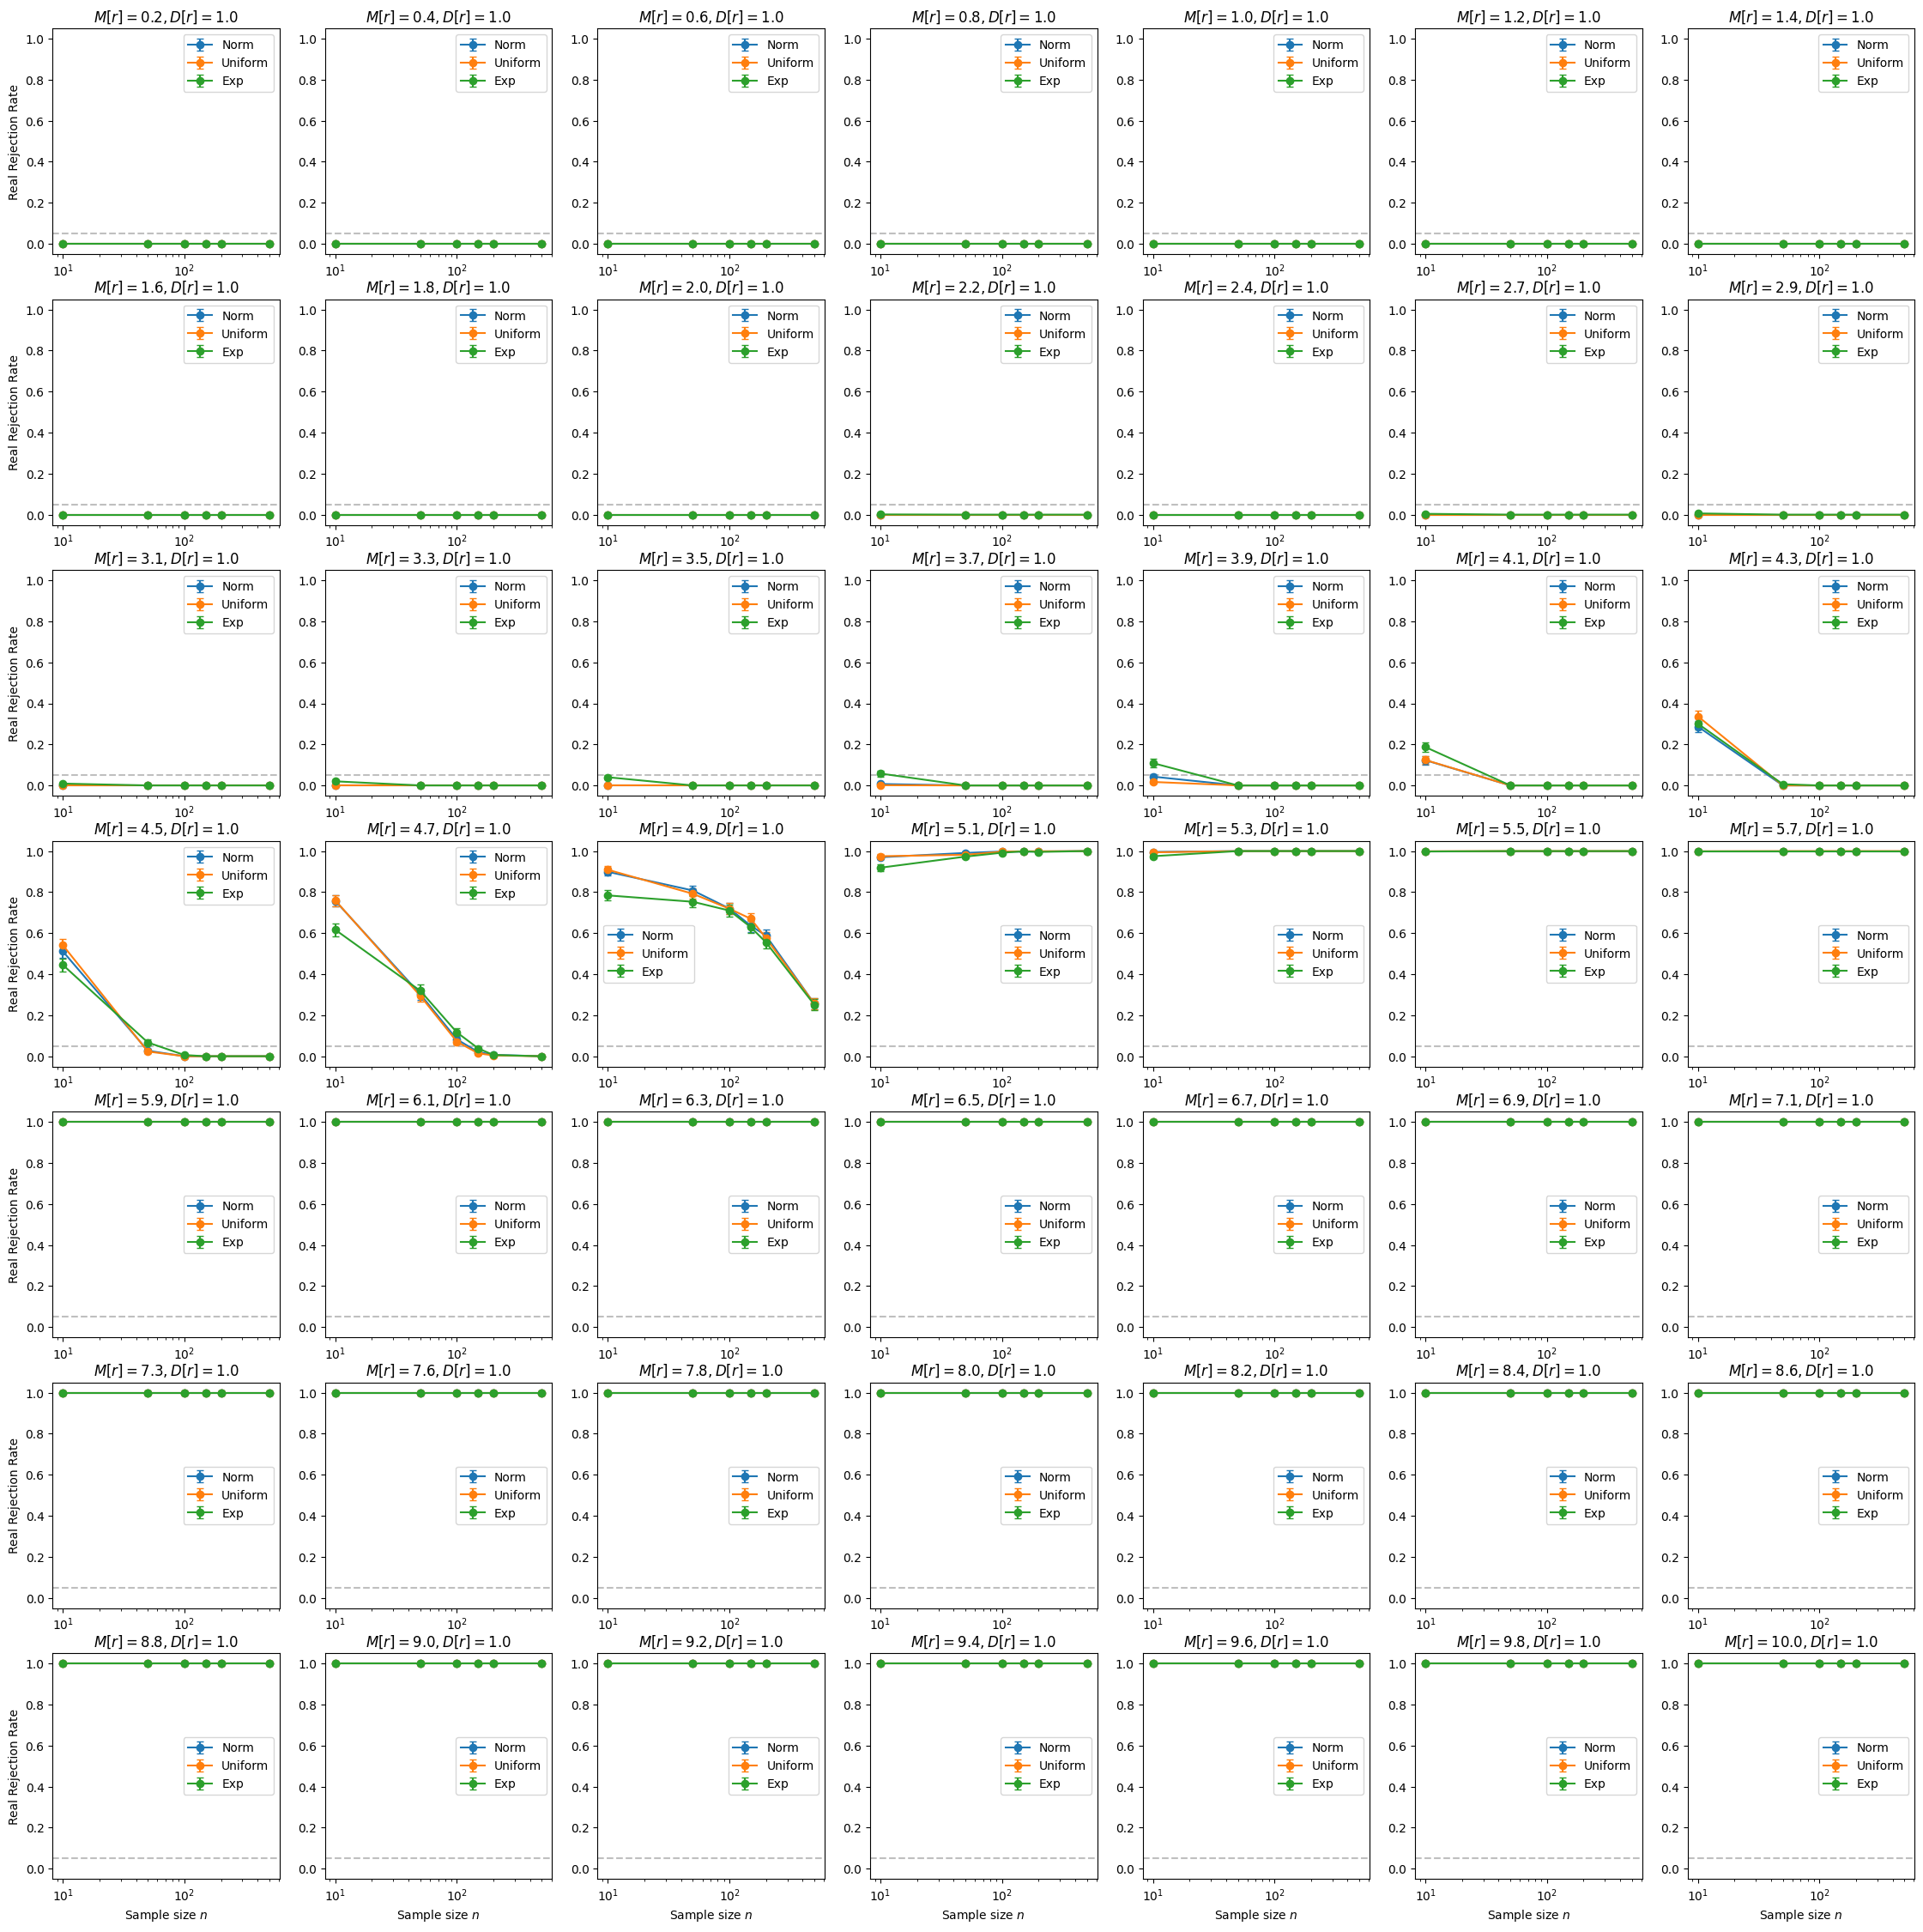

In [9]:
_, axes = plt.subplots(7, 7, figsize=(28, 28))
for i, e in tqdm(enumerate(ES), total=num_tries):
    ax: plt.Axes = axes[i // 7][i % 7]
    test_solution(check_expected_value, frr=FRR, far=FAR, hypothesis_kwargs={'less_than': A}, distributions=get_distributions(E=e, D=1), ax=ax)
for i in range(7):
    axes[i][0].set_ylabel('Real Rejection Rate')
    axes[6][i].set_xlabel('Sample size $n$')
plt.show()

## Task 4

Функция проверки сложной гипотезы о дисперсии случайной величины. Возвращает `True`, если следует принять гипотезу $H_0: \text{Var}[r] < \sigma^2$ с заданными $\text{FRR}$ и $\text{FAR}$.

In [10]:
def check_variance(sample, less_than: float, frr, far) -> bool:
    n = len(sample)
    var = np.var(sample)
    term = var * (n - 1)
    I_1_r = term / quant('Chi Squared', frr, n - 1)
    if I_1_r < less_than:
        return True
    I_2_l = term / quant('Chi Squared', 1 - far, n - 1)
    if I_2_l > less_than:
        return False
    else:
        return False

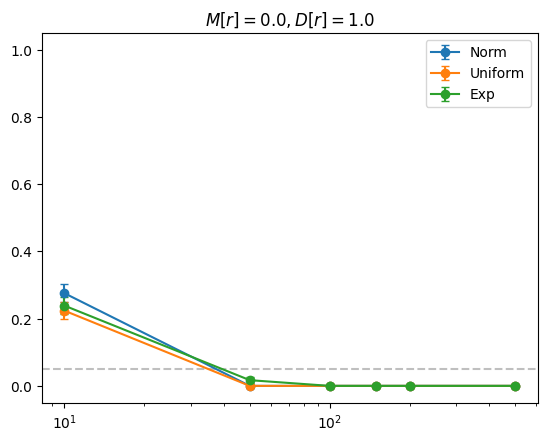

In [11]:
test_solution(check_variance, frr=FRR, far=FAR, hypothesis_kwargs={'less_than': SIGMA_SQUARED}, distributions=get_distributions(E=0, D=1))

In [ ]:
DS = np.linspace(1, 2 * SIGMA_SQUARED, num=int((2 * SIGMA_SQUARED - 1) // STEP) + 1)
num_tries = len(DS)

array([1.        , 1.20833333, 1.41666667, 1.625     , 1.83333333,
       2.04166667, 2.25      , 2.45833333, 2.66666667, 2.875     ,
       3.08333333, 3.29166667, 3.5       , 3.70833333, 3.91666667,
       4.125     , 4.33333333, 4.54166667, 4.75      , 4.95833333,
       5.16666667, 5.375     , 5.58333333, 5.79166667, 6.        ])

100%|██████████| 25/25 [00:29<00:00,  1.19s/it]


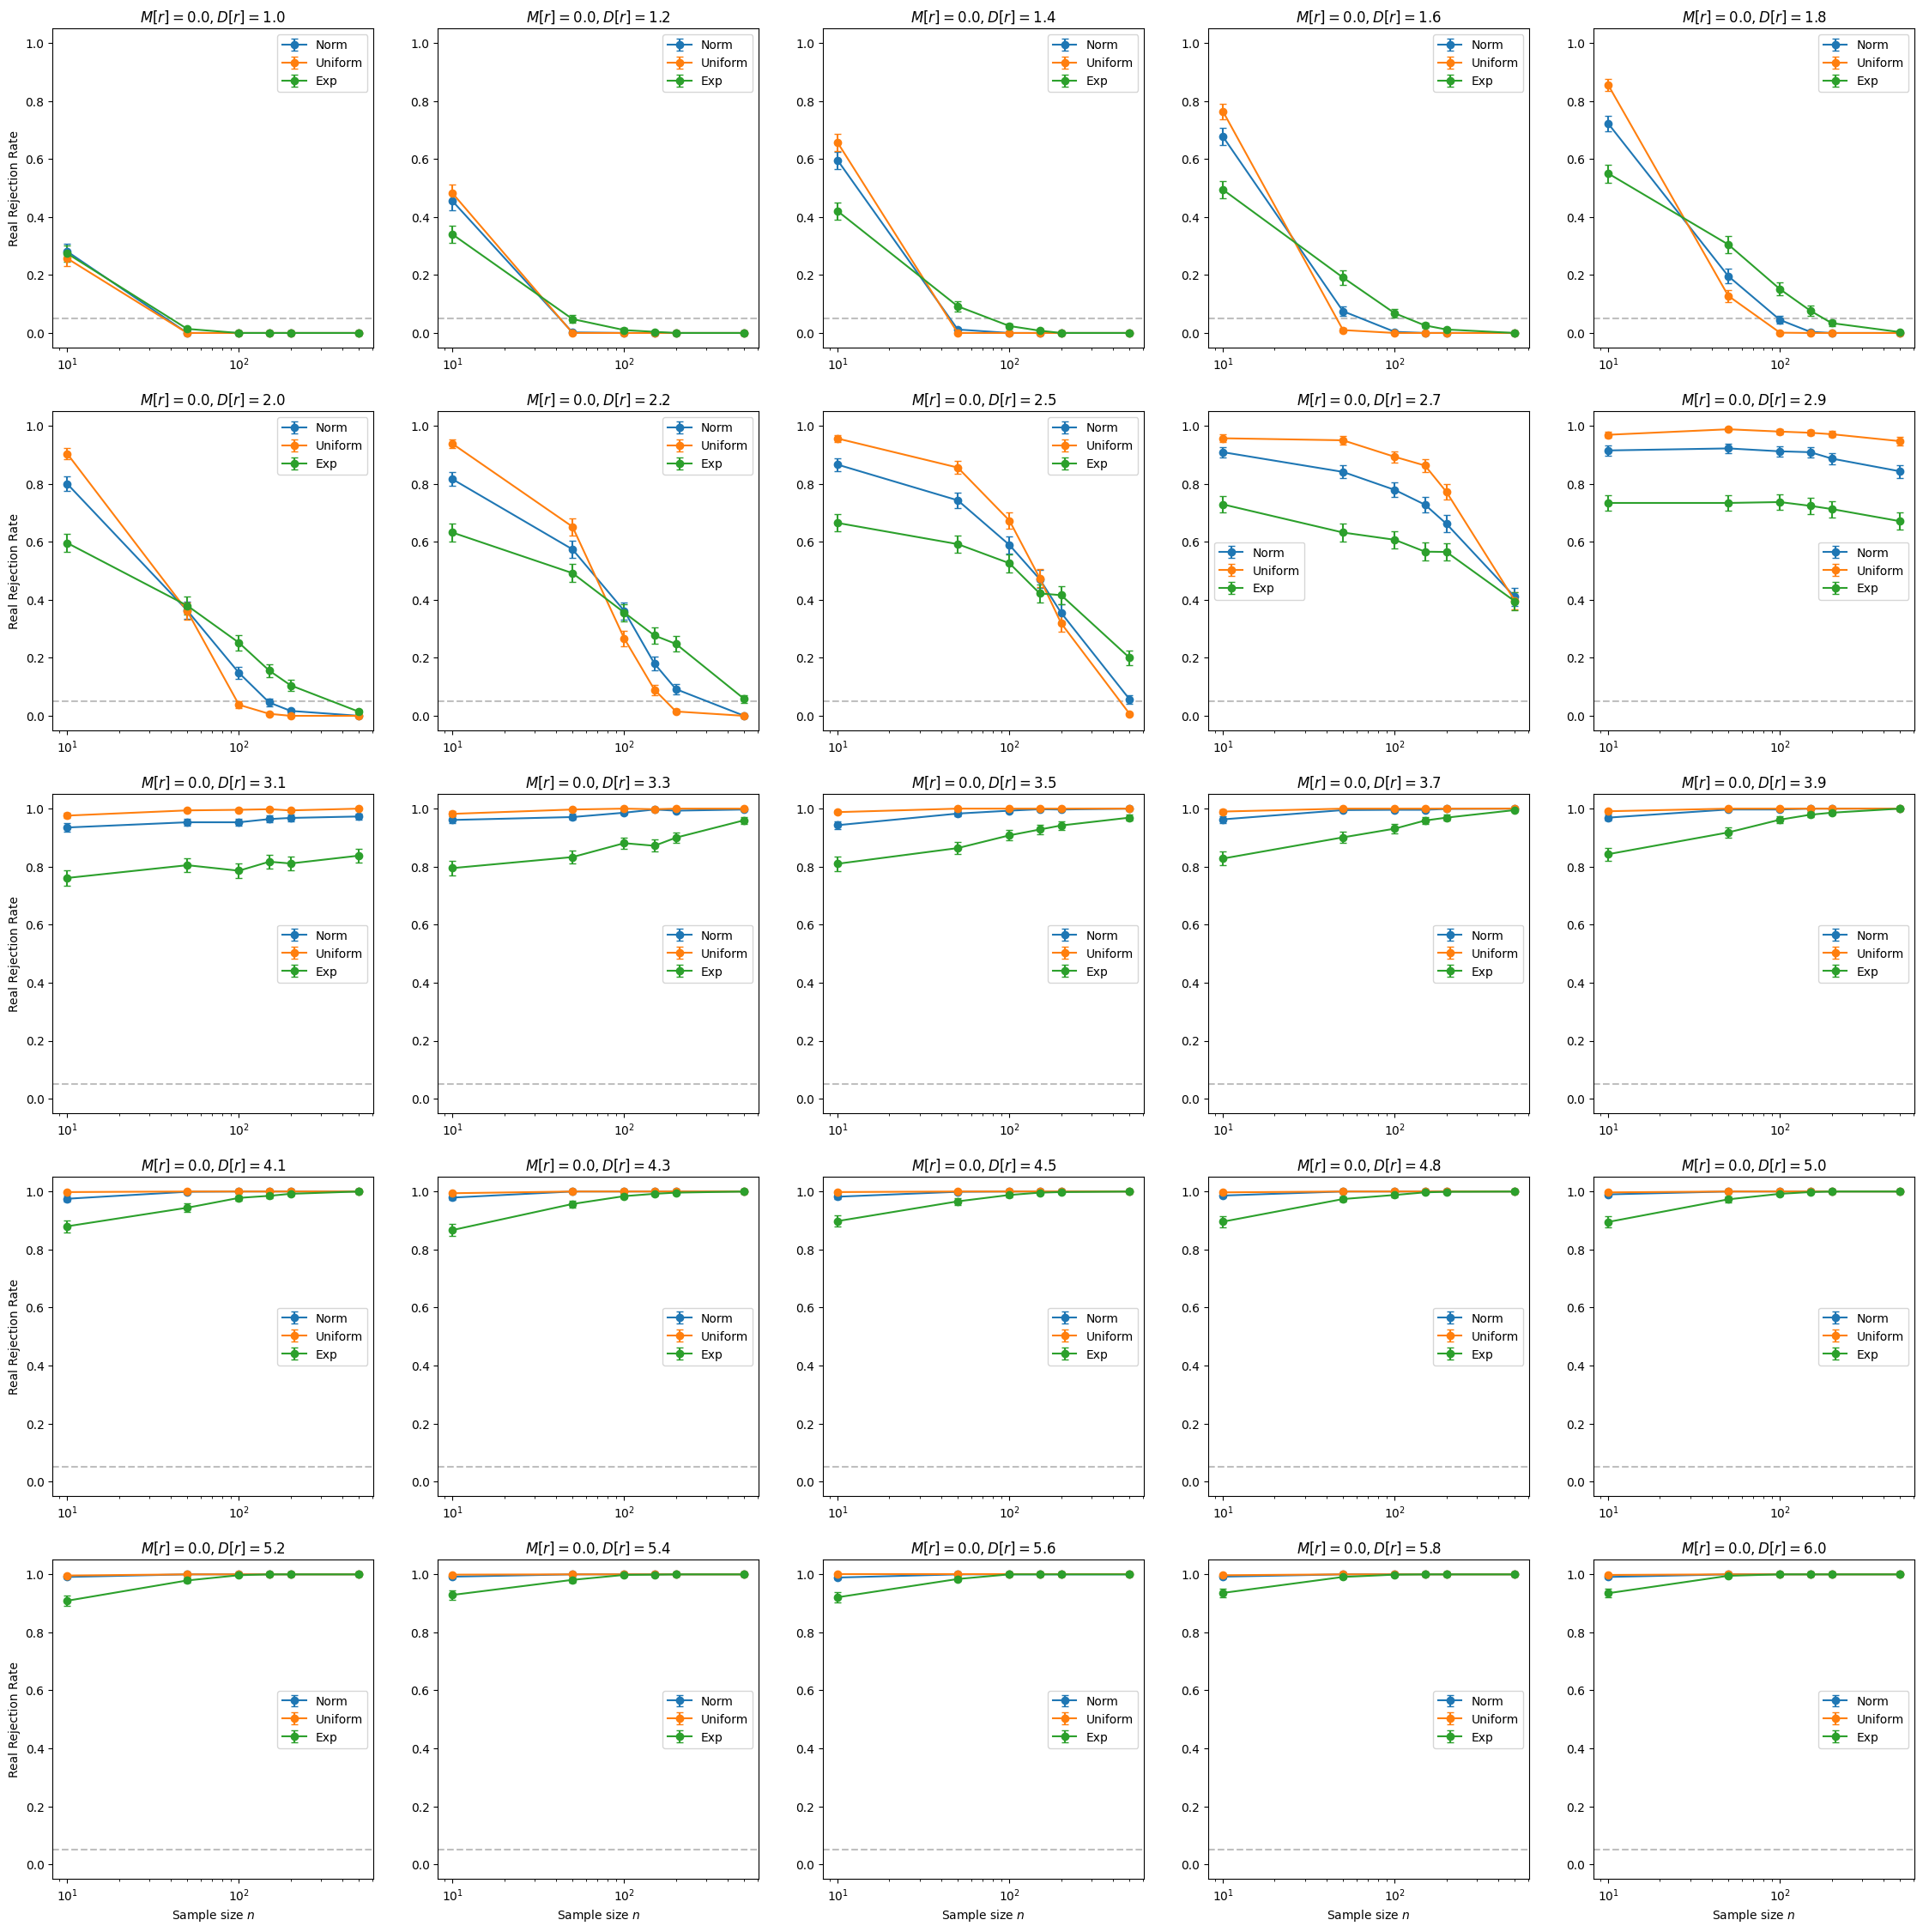

In [13]:
_, axes = plt.subplots(5, 5, figsize=(28, 28))
for i, var in tqdm(enumerate(DS), total=num_tries):
    ax: plt.Axes = axes[i // 5][i % 5]
    test_solution(check_variance, frr=FRR, far=FAR, hypothesis_kwargs={'less_than': SIGMA_SQUARED}, distributions=get_distributions(E=0, D=var), ax=ax)
for i in range(5):
    axes[i][0].set_ylabel('Real Rejection Rate')
    axes[4][i].set_xlabel('Sample size $n$')
plt.show()

## Task 5

Функция проверки сложной гипотезы о квантили случайной величины. Возвращает `True`, если следует принять гипотезу $H_0: r_{q} < d$ с заданными $\text{FRR}$ и $\text{FAR}$, где $r_q$ - $q\cdot 100$%-ая квантиль распределения $r$.

In [14]:
def check_quantile(sample, q: float, less_than: float, frr: float, far: float) -> bool:
    n = len(sample)
    sample = sorted(sample)
    qn = q * n
    term = math.sqrt(qn * (1 - q))
    k_1 = math.ceil(qn + term * quant('Norm', 1 - frr))
    I_1_r = sample[k_1] if k_1 < n else np.inf
    if I_1_r < less_than:
        return True
    k_2 = math.floor(qn - term * quant('Norm', 1 - far))
    I_2_l = sample[k_2] if k_2 >= 0 else -np.inf
    if I_2_l > less_than:
        return False
    else:
        return False

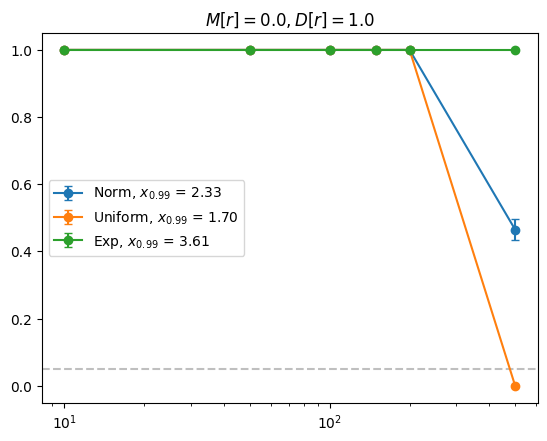

In [15]:
QUANTILE = 3
test_solution(check_quantile, frr=FRR, far=FAR, hypothesis_kwargs={'q': 0.99, 'less_than': QUANTILE}, distributions=get_distributions(E=0, D=1), include_label='quantile')

In [16]:
ES = np.linspace(0, QUANTILE, num=int(QUANTILE // STEP) + 2)
num_tries = len(ES)

100%|██████████| 16/16 [00:19<00:00,  1.24s/it]


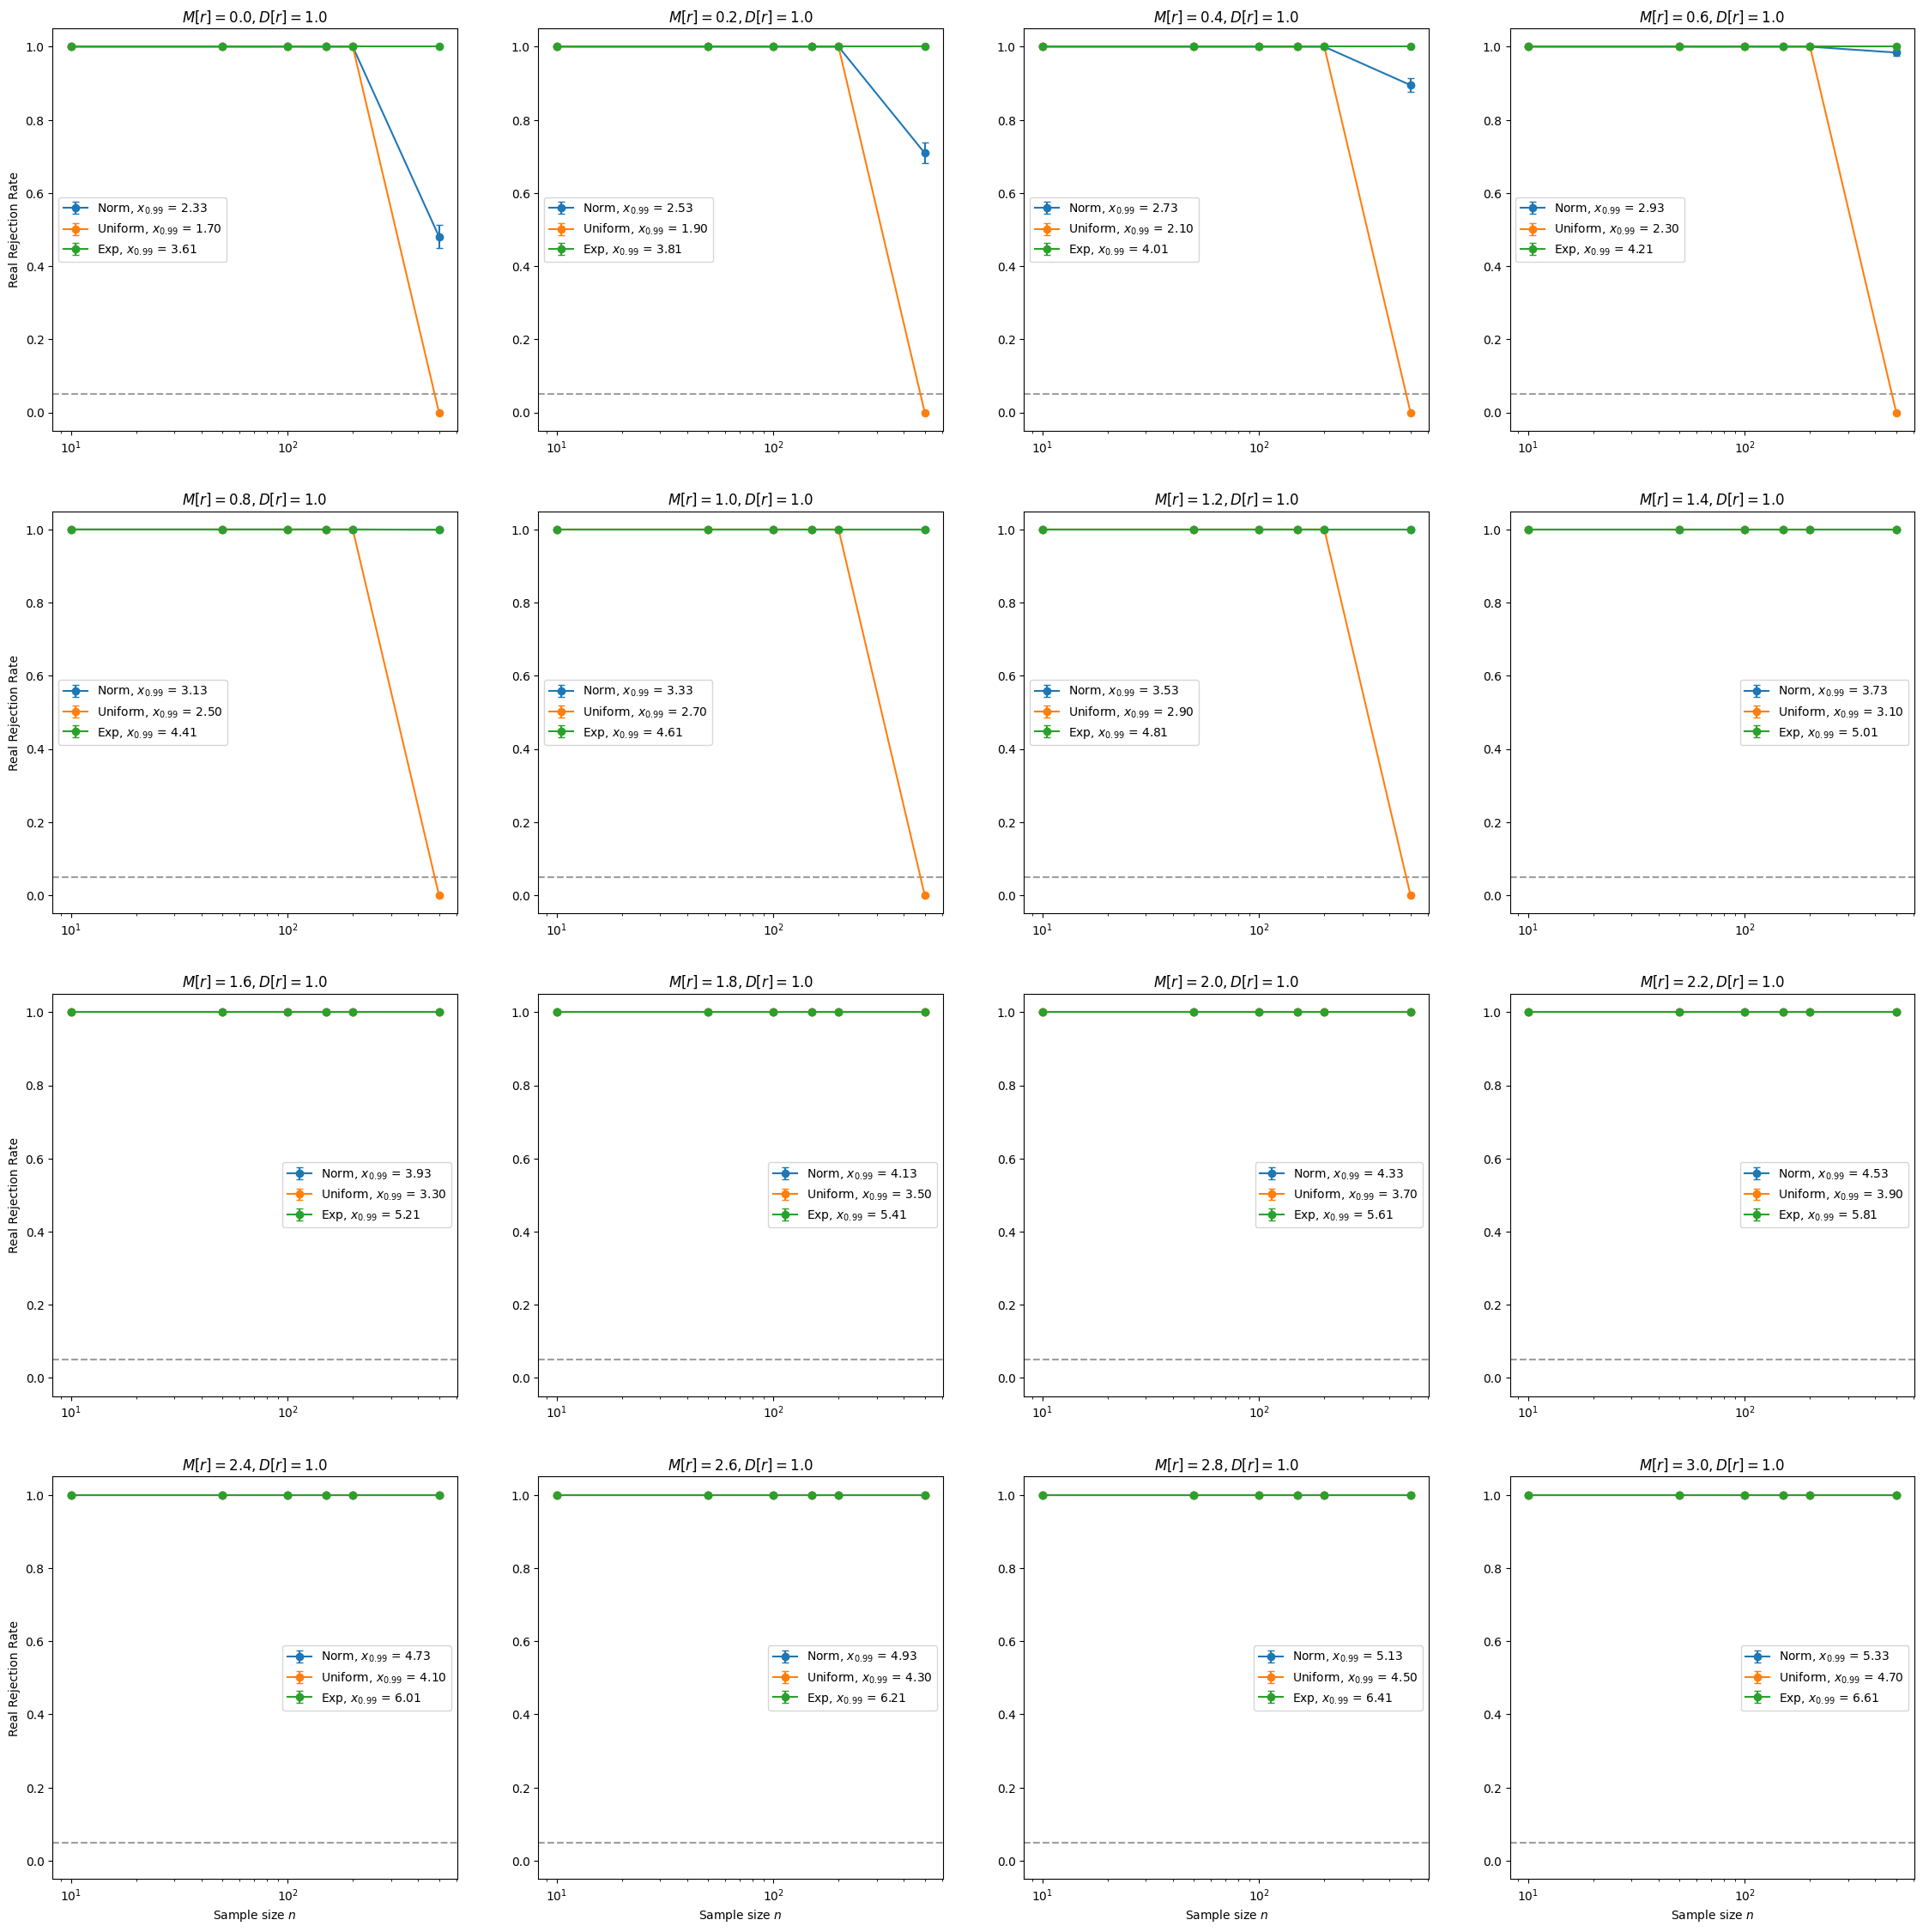

In [17]:
_, axes = plt.subplots(4, 4, figsize=(28, 28))
for i, e in tqdm(enumerate(ES), total=num_tries):
    ax: plt.Axes = axes[i // 4][i % 4]
    ax.axhline(FRR, linestyle='--', color='gray', alpha=0.5)
    test_solution(check_quantile, frr=FRR, far=FAR, hypothesis_kwargs={'q': 0.99, 'less_than': QUANTILE}, distributions=get_distributions(E=e, D=1), ax=ax, include_label='quantile')
    
for i in range(4):
    axes[i][0].set_ylabel('Real Rejection Rate')
    axes[3][i].set_xlabel('Sample size $n$')
plt.show()